# Intro to AI-driven Science on Supercomputers

## Week 4 Homework

#### Dan Horner (danhorner@berkeley.edu)
---

# ResNet34 Training

## ResNet34 Training on ThetaGPU

I modified the submission script (train_resnet34_thetagpu_DAH.sh) to point to my branch of the code and ran it on ThetaGPU.

---
Contents of [job log](10109896.keepcobaltlog) from ThetaGPU

---
    Jobid: 10109896
    qsub --mode script -t 60 -q single-gpu -A ALCFAITP -n 1 ./train_resnet34_thetagpu_DAH.sh
    Wed Oct 12 02:46:13 2022 +0000 (UTC) submitted with cwd set to: /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks
    jobid 10109896 submitted from terminal /dev/pts/14
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Command: '/usr/bin/ssh' 'thetagpu06-gpu0' '/usr/bin/cobalt-launcher.py' '--nf' '/var/tmp/cobalt.10109896' '--jobid' '10109896' '--cwd' '/lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks' '--env' 'COBALT_JOBID=10109896' '/lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/./train_resnet34_thetagpu_DAH.sh'
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Environment:
    Wed Oct 12 02:46:34 2022 +0000 (UTC) SHELL=/bin/bash
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_NODEFILE=/tmp/tmpk1X0mg
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_PARTNAME=thetagpu06-gpu0
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_JOBID=10109896
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_STARTTIME=1665542781
    Wed Oct 12 02:46:34 2022 +0000 (UTC) LOGNAME=hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) USER=hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_ENDTIME=1665546381
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_PARTSIZE=1
    Wed Oct 12 02:46:34 2022 +0000 (UTC) HOME=/home/hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_JOBSIZE=1
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stdin received from /dev/null
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stdout sent to /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/10109896.output
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stderr sent to /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/10109896.error
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 03:46:35 2022 +0000 (UTC) Info: maximum execution time exceeded; initiating job termination
---
(**Note:** I renamed the job log and output files to maintain them in the repo and not mangle my .gitignore)

Inspecting the [job output](10109896.keepoutput) we can see that almost two epochs were able to complete within the 1 hour execution limit; Epoch 0 completed and Epoch 1 completed 4240 of 5004 steps.

## Model Training Performance Charts

### Set Up

In [225]:
import numpy as np
import pandas as pd

import re

import plotnine as p9
from plotnine import * 
p9.options.figure_size = (15, 12)

import patchworklib as pw

training_report = './10109896.keepoutput'

clr_dict = {'Epoch 0': 'red', 'Epoch 1': 'blue'}

### Helper function for plotting

In [226]:
def base_plot(df, v, ylab, clr_dict):
    pl = (ggplot() 
          + geom_hline(yintercept = 0, colour = 'grey', size = 0.3)
          + geom_line(df, aes(x = 'step', y = v, colour = 'epoch_str'), alpha = 0.3)
          + geom_line(df, aes(x = 'step', y = v + '_roll', colour = 'epoch_str'))
          + scale_x_continuous(name = 'training step')
          + scale_colour_manual(values = clr_dict)
          + scale_y_continuous(name = ylab)
          + theme(
              text = element_text(size = 12),
              legend_position='none',
              legend_title = element_blank(),             
          )
     )

    return(pl)

### Read in and parse the job output, creating a pandas DataFrame holding the values

In [227]:
with open(training_report) as f:
    lines = f.readlines()
li = []
for line in lines:
    if(re.match(r'^Finished step ', line)):
        x = re.search(r'^Finished step (?P<step>\d*) of (?P<tot_steps>\d*) in epoch (?P<epoch>\d*),loss=(?P<loss>[\d.]*), acc=(?P<acc>[\d.]*) \((?P<ips>[\d.]*)', line)
        li.append(x.groupdict())

df = pd.DataFrame(li)

df[['step', 'tot_steps', 'epoch']] = df[['step', 'tot_steps', 'epoch']].astype(int)
df[['loss', 'acc', 'ips']] = df[['loss', 'acc', 'ips']].astype(float)

df[['loss_roll', 'acc_roll', 'ips_roll']] = df[['loss', 'acc', 'ips']].rolling(window = 50, min_periods=0).mean()
df['epoch_str'] = 'Epoch ' + df['epoch'].astype(str)

### Training loss

Plotting the loss (Note the $\log_{10}$ y-axis)

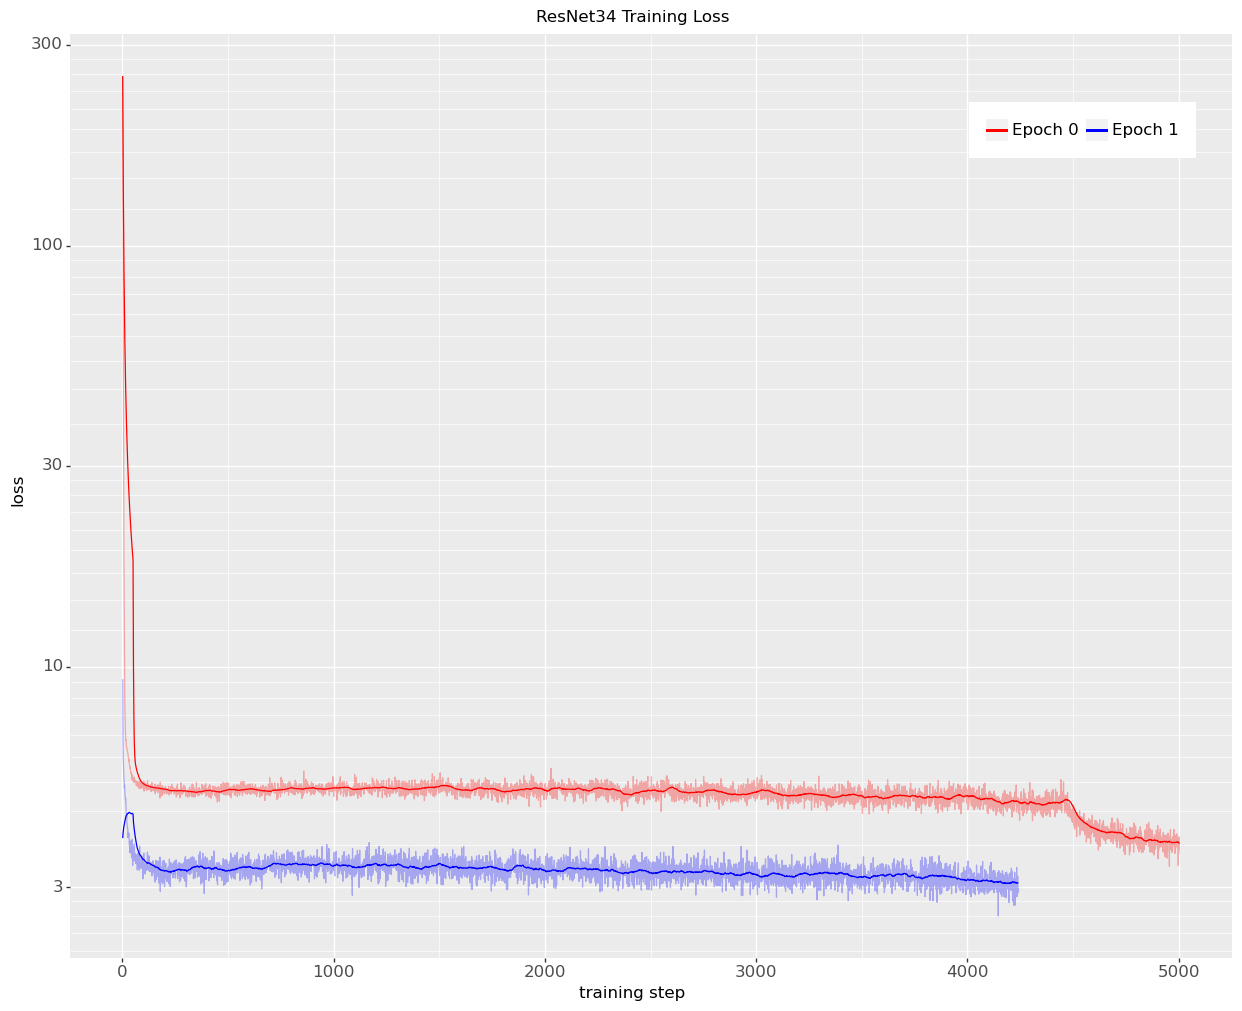

In [216]:
pl = (base_plot(df, 'loss', 'loss', clr_dict) 
      + ggtitle('ResNet34 Training Loss')
      + scale_y_log10(name = 'loss')
      + theme(
          legend_position = (0.8, 0.8)
      )
     )
print(pl)

### Comparing aspects


Stuff here... 

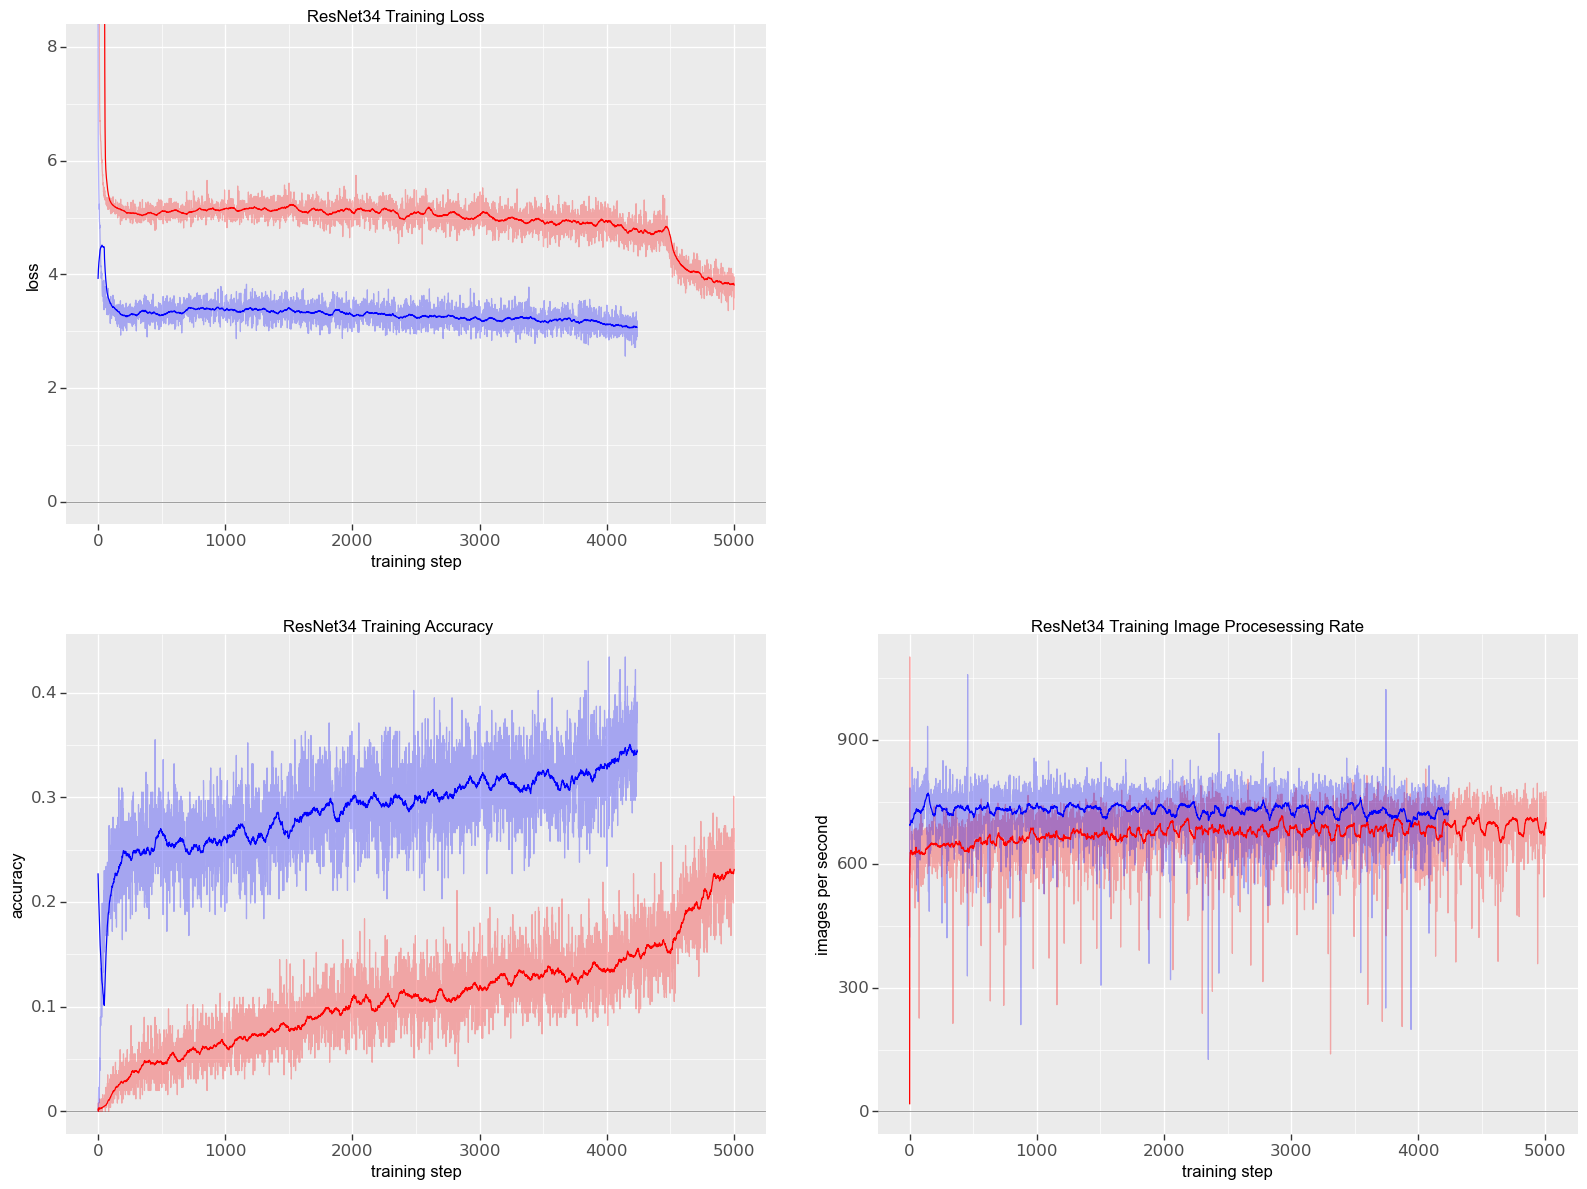

In [218]:
pl_loss = base_plot(df, 'loss', 'loss', clr_dict) + ggtitle('ResNet34 Training Loss') + coord_cartesian(ylim=(0, 8))
pl_acc = base_plot(df, 'acc', 'accuracy', clr_dict) + ggtitle('ResNet34 Training Accuracy')
pl_ips = base_plot(df, 'ips', 'images per second', clr_dict) + ggtitle('ResNet34 Training Image Procesessing Rate')

pl_loss = pw.load_ggplot(pl_loss, figsize=(7,5))
pl_acc = pw.load_ggplot(pl_acc, figsize=(7,5))
pl_ips = pw.load_ggplot(pl_ips, figsize=(7,5))

pl_pw = ((pl_loss/pl_acc)[pl_acc]|pl_ips)
pl_pw.savefig()

## Wrap up...